# Training an LSTM NN

In [214]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [215]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

print(tf.__version__)

2.9.0


Import features and targets

In [216]:
df_X = pd.read_csv('data/features_matrix.csv')
df_X

,visit_id,patient_id,visit_month,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,ADDLGKGGNEESTKTGNAGSR,ADSGEGDFLAEGGGVR,AEAQEAEDQQAR,...,VYAC(UniMod_4)EVTHQGLSSPVTK,WELALGR,WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR,YANC(UniMod_4)HLAR,YFIDFVAR,YGLVTYATYPK,YIETDPANR,YLYEIAR,YTTEIIK,YYC(UniMod_4)FQGNQFLR
0,55_0,55,0,53855.6,NaN,19735.4,114400.0,39389.3,NaN,9481.83,...,0,0,0,0,0,0,0,0,0,0
1,55_6,55,6,45251.9,49927.5,23820.4,90539.4,40871.1,44205.80,10315.90,...,0,0,0,0,0,0,0,0,0,0
2,55_12,55,12,53000.9,45519.2,17813.5,147312.0,35002.7,39179.60,7138.93,...,0,0,0,0,0,0,0,0,0,0
3,55_36,55,36,58108.4,52374.0,19373.3,64356.1,44147.9,39639.60,9959.98,...,0,0,0,0,0,0,0,0,0,0
4,942_6,942,6,42682.6,25698.8,17130.6,86471.5,22944.8,68677.50,5938.09,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,64674_48,64674,48,31434.3,11667.5,10309.1,12677.8,NaN,37408.50,NaN,...,0,0,0,0,0,0,0,0,0,0
564,65043_0,65043,0,95033.0,57483.7,11610.0,270739.0,46225.1,9668.03,5673.29,...,0,0,0,0,0,0,0,0,0,0
565,65043_12,65043,12,76532.7,54260.6,11631.9,230169.0,43775.4,50476.90,7533.18,...,0,0,0,0,0,0,0,0,0,0
566,65043_24,65043,24,75401.6,NaN,13313.9,220202.0,30188.3,16739.50,7079.75,...,0,0,0,0,0,0,0,0,0,0


In [217]:
df_y = pd.read_csv('data/target_matrix.csv')
df_y

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,0.0
1,55_6,55,6,8.0,10.0,34.0,0.0
2,55_12,55,12,10.0,10.0,41.0,0.0
3,55_18,55,18,7.0,13.0,38.0,0.0
4,55_24,55,24,16.0,9.0,49.0,0.0
...,...,...,...,...,...,...,...
1503,65043_36,65043,36,2.0,7.0,5.0,0.0
1504,65043_48,65043,48,7.0,6.0,13.0,0.0
1505,65043_54,65043,54,4.0,8.0,11.0,1.0
1506,65043_60,65043,60,6.0,6.0,16.0,1.0


Reshape target variable so that each feature sample has a prediction window of 4 timesteps, like
$t + (0,6,12,24)$

In [218]:
time_steps = np.array([0,6,12,24])
yy = []   # target (samples, month, updrs)

for patient in df_X.patient_id.unique():
    yy_patient = df_y.query("patient_id == @patient").set_index("visit_month")
    for visit in df_X[df_X.patient_id == patient].visit_month:
        new_sample = yy_patient.loc[list(time_steps+ visit)]
        new_line = new_sample[['updrs_1','updrs_2','updrs_3','updrs_4']].to_numpy()
        new_meta = np.array([patient,visit])
        
        yy.append(new_line)
        
yy = np.array(yy)

print("yy shape (samples, 4*target timestep, 4*target values): \n", yy.shape)
print("df_X shape (samples, 2*metadata + 582*features): \n",df_X.shape)

yy shape (samples, 4*target timestep, 4*target values): 
 (568, 4, 4)
df_X shape (samples, 2*metadata + 582*features): 
 (568, 585)


Test train split, before scaling. Then scale using Min-Max.

In [219]:
X_train, X_test, y_train, y_test = train_test_split(df_X, yy, test_size=0.2, random_state=12)

### Drop meta data from features matrix
meta_names = ['visit_id','patient_id','visit_month']

# Train
meta_train = X_train[meta_names].copy() 
X_train = X_train.drop(meta_names, axis=1)

# Test
meta_test = X_test[meta_names].copy() 
X_test = X_test.drop(meta_names, axis=1)

### Scale numeric features

# Get names of features
num_feat_names = pd.read_csv('data/numeric_peptide_features.csv',header=None).values.flatten()
bin_feat_names = pd.read_csv('data/binary_peptide_features.csv',header=None).values.flatten()

# Seperate numeric features
X_train_num = X_train[num_feat_names].fillna(0)
X_test_num = X_test[num_feat_names].fillna(0)

# Scale numeric
scaler = MinMaxScaler()

X_train_num_np = scaler.fit_transform(X_train_num) # fit to train data
X_test_num_np  = scaler.transform(X_test_num) # only tranform test data, no data leakage

# Put features back together again
X_train[num_feat_names] = X_train_num_np
X_test[num_feat_names]  = X_test_num_np

# 
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()



In [220]:
X_train_np = X_train_np.reshape(-1, 1, 582)
X_train_np.shape

(454, 1, 582)

In [221]:
X_test_np = X_test_np.reshape(-1, 1, 582)
X_test_np.shape

(114, 1, 582)

In [222]:
y_train.shape

(454, 4, 4)

## Baseline model
Create model architecture for the baseline. The baseline model is merely learning to estimate the mode or mean of UPDRS scores and is probably underfitting. I may need to work with different loss metrics and a different architecture. The problem of high dimesionality might never go away.

In [223]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(1, 582), return_sequences=False))
model.add(tf.keras.layers.Reshape((1, 128)))  # Reshape the output of the LSTM layer
model.add(tf.keras.layers.UpSampling1D(size=4))  # Repeat the output of the LSTM layer 4 times
model.add(LSTM(128, return_sequences=True))
model.add(TimeDistributed(Dense(4)))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Display the model summary
model.summary()



Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 128)               364032    
                                                                 
 reshape_10 (Reshape)        (None, 1, 128)            0         
                                                                 
 up_sampling1d_7 (UpSampling  (None, 4, 128)           0         
 1D)                                                             
                                                                 
 lstm_45 (LSTM)              (None, 4, 128)            131584    
                                                                 
 time_distributed_13 (TimeDi  (None, 4, 4)             516       
 stributed)                                                      
                                                                 
Total params: 496,132
Trainable params: 496,132
Non-t

In [224]:
smod_history = model.fit(X_train_np, y_train,
          validation_split=0.2,
          epochs=10,
)



Epoch 1/10
12/12 [==============================] - 6s 172ms/step - loss: 193.0993 - mse: 193.0993 - val_loss: 138.6043 - val_mse: 138.6043
Epoch 2/10
12/12 [==============================] - 0s 15ms/step - loss: 120.5399 - mse: 120.5399 - val_loss: 87.2231 - val_mse: 87.2231
Epoch 3/10
12/12 [==============================] - 0s 19ms/step - loss: 90.4130 - mse: 90.4130 - val_loss: 72.5385 - val_mse: 72.5385
Epoch 4/10
12/12 [==============================] - 0s 13ms/step - loss: 81.2732 - mse: 81.2732 - val_loss: 64.9963 - val_mse: 64.9963
Epoch 5/10
12/12 [==============================] - 0s 13ms/step - loss: 75.7405 - mse: 75.7405 - val_loss: 60.6954 - val_mse: 60.6954
Epoch 6/10
12/12 [==============================] - 0s 14ms/step - loss: 72.8447 - mse: 72.8447 - val_loss: 57.7107 - val_mse: 57.7107
Epoch 7/10
12/12 [==============================] - 0s 13ms/step - loss: 70.6947 - mse: 70.6947 - val_loss: 55.8202 - val_mse: 55.8202
Epoch 8/10
12/12 [==============================

4/4 [==============================] - 1s 6ms/step


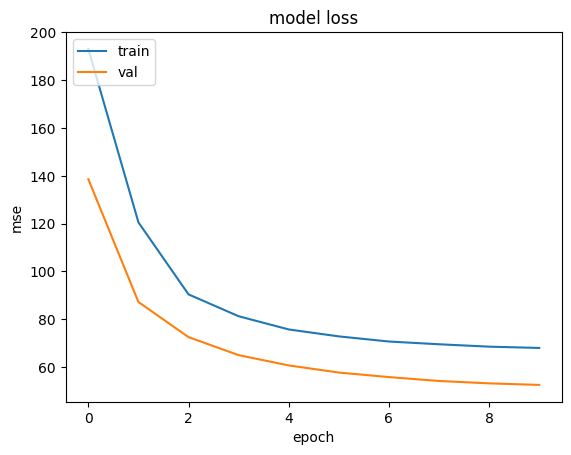

In [225]:
preds = model.predict(X_test_np)
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [226]:
preds



array([[[ 6.395228 ,  6.231618 , 16.51923  ,  1.0717294],
        [ 8.123869 ,  7.7355237, 21.46501  ,  1.3794012],
        [ 8.408001 ,  8.00355  , 22.210983 ,  1.4291174],
        [ 8.448363 ,  8.042057 , 22.314783 ,  1.4359853]],

       [[ 6.409456 ,  6.2453156, 16.551453 ,  1.0748051],
        [ 8.12578  ,  7.7370186, 21.469604 ,  1.3799827],
        [ 8.40816  ,  8.0032215, 22.212076 ,  1.4293503],
        [ 8.448262 ,  8.041469 , 22.315374 ,  1.4361725]],

       [[ 6.401457 ,  6.2375717, 16.533783 ,  1.072885 ],
        [ 8.124726 ,  7.7362   , 21.467093 ,  1.3796339],
        [ 8.408087 ,  8.003437 , 22.21148  ,  1.4292145],
        [ 8.448337 ,  8.041831 , 22.315054 ,  1.4360633]],

       ...,

       [[ 6.429292 ,  6.2641454, 16.596436 ,  1.0792586],
        [ 8.128576 ,  7.7393312, 21.476017 ,  1.380758 ],
        [ 8.408358 ,  8.002729 , 22.213594 ,  1.4296829],
        [ 8.448094 ,  8.040605 , 22.31619  ,  1.4364437]],

       [[ 6.3835874,  6.2205935, 16.493586 ,  1.069

In [227]:
y_test

array([[[11.,  6., 15.,  3.],
        [ 9.,  4.,  6.,  0.],
        [13.,  8.,  8.,  0.],
        [14., 10.,  6.,  0.]],

       [[ 8.,  2., 15.,  2.],
        [13., 10., 16.,  5.],
        [11.,  5., 18.,  2.],
        [ 7.,  4., 15.,  1.]],

       [[ 3.,  0.,  0.,  0.],
        [ 1.,  0.,  1.,  0.],
        [ 4.,  1.,  9.,  0.],
        [ 2.,  2.,  0.,  0.]],

       ...,

       [[ 9.,  6., 10.,  0.],
        [10.,  6., 15.,  0.],
        [10., 10., 11.,  7.],
        [12.,  9., 32.,  1.]],

       [[ 9., 11., 19.,  0.],
        [12., 13., 21.,  0.],
        [12., 13., 27.,  0.],
        [13., 12., 24.,  5.]],

       [[18., 18., 49.,  0.],
        [15., 16., 48.,  0.],
        [15., 15., 38.,  0.],
        [15., 19., 39.,  0.]]])

Now define the function SMAPE for evaluating the model, since keras doesn't have this metric yet. 

In [228]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))